# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [167]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.


In [168]:
# Load the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [169]:
print('Number of rows:', azdias.shape[0])
print('Number of features:', azdias.shape[1])
azdias.head(5)

Number of rows: 891221
Number of features: 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [170]:
azdias.dtypes.value_counts()

float64    49
int64      32
object      4
dtype: int64

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.


In [171]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [172]:
# replace to np.nan according to feat_info 

azdias_mapped = azdias.copy()
features = feat_info['attribute']

for feature in features:
    
    # get missing_or_unknown for current feature and put in a list
    missing_str = feat_info[feat_info['attribute'] == feature]['missing_or_unknown']
    s = missing_str.values[0][1:][:-1].split(',')

    if s[0]: # if there is missing_or_unknown values to replace, do it
        if(azdias_mapped.dtypes[feature] == 'object'):
            d = {n: np.nan for n in list(map(lambda x: str(x), s))}
        else:
            d = {n: np.nan for n in list(map(lambda x: int(x), s))}

        azdias_mapped[feature] = azdias_mapped[feature].replace(d)


In [173]:
azdias_mapped.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [174]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
na_counts = azdias_mapped.isnull().sum()
na_counts[:10]

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
dtype: int64

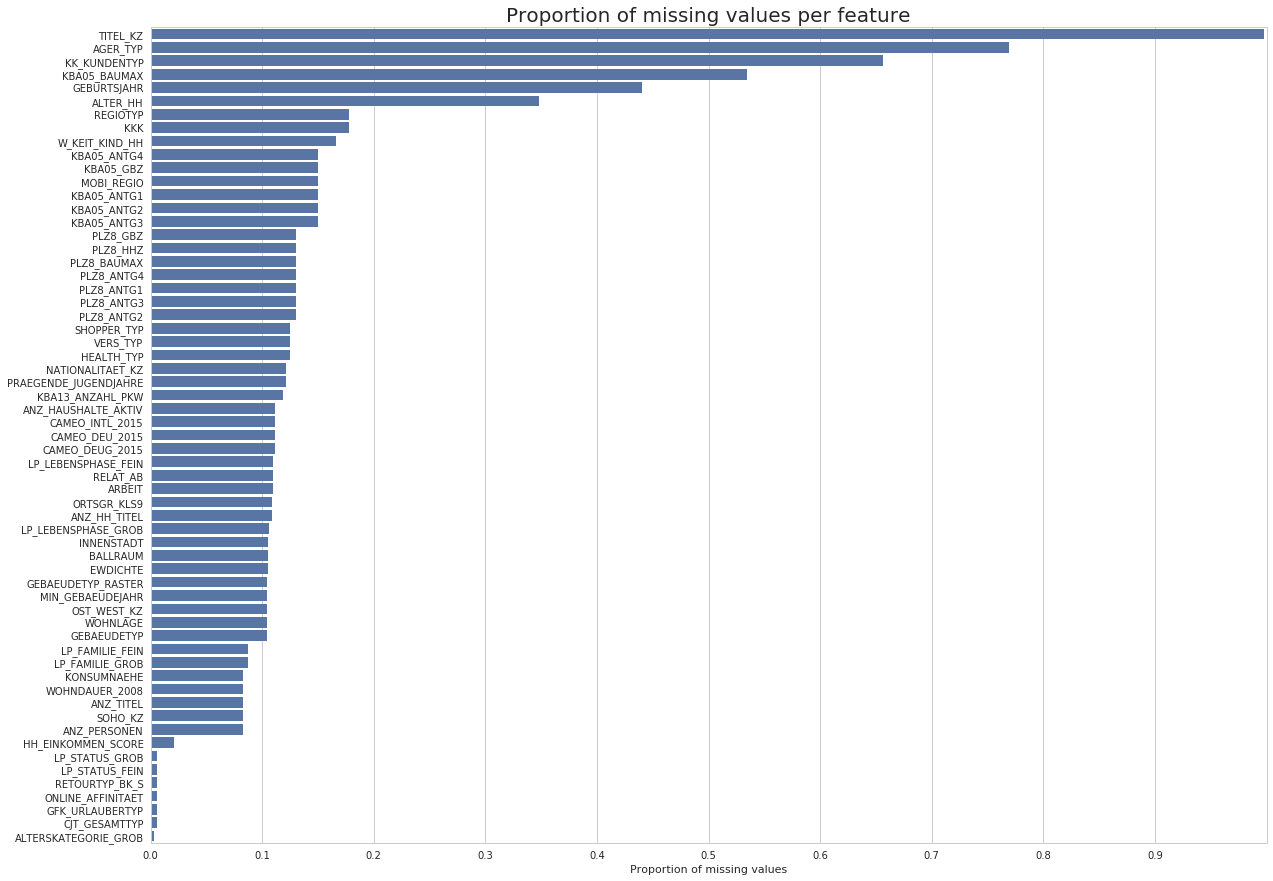

In [175]:
# Investigate patterns in the amount of missing data in each column.

# plot columns that have missing values
base_color = sns.color_palette()[0]
na_counts_subset = na_counts[na_counts != 0]

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(20, 15))
na_counts_subset = na_counts_subset.sort_values(ascending=False)
x_values = na_counts_subset / azdias.shape[0]
g = sns.barplot(x=x_values, y=na_counts_subset.index, color=base_color)

plt.xticks(np.arange(0, 1, 0.1))
plt.title('Proportion of missing values per feature',fontdict={'fontsize': 20});
ax.set(xlim=(0, 1), xlabel="Proportion of missing values");


In [176]:
# Levels of information of missing data in columns with more then 20% of values missing

outliers_features = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP', 'KBA05_BAUMAX', 
                     'GEBURTSJAHR','ALTER_HH']
feat_info[feat_info['attribute'].isin(outliers_features)]


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
11,GEBURTSJAHR,person,numeric,[0]
40,TITEL_KZ,person,categorical,"[-1,0]"
43,ALTER_HH,household,interval,[0]
47,KK_KUNDENTYP,household,categorical,[-1]
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"


In [177]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_mapped_drop = azdias_mapped.drop(labels=outliers_features, axis=1)
azdias_mapped_drop.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

-  From the plot 'Proportion of missing values per feature' it is possible to see that 6 features have more than 20% of missing values. These features are:
<br>

    -  **TITEL_KZ**: Academic title flag (e.g Prof., Dr.)
    <br>
    -  **AGER_TYP**: Best-ager typology (e.g passive elderly, cultural elderly)
      <br>
    -  **KK_KUNDENTYP**: Consumer pattern over past 12 months (e.g regular customer, active customer)
    <br>
    -  **KBA05_BAUMAX**: Most common building type within the microcell(e.g mainly 1-2 family homes in the microcell)
    <br>
    -  **GEBURTSJAHR**: Year of Birth
    <br>
    -  **ALTER_HH**: Birthdate of head of household
    <br>
<br>
-  The table below shows the amount of missing information per feature:
 
| Feature | # of missing values | Percentage| Level of information|
| --- | --- | --- | --- |
| TITEL_KZ | 889061 | 99.75% |person|
| AGER_TYP | 685843 | 76.95% |person|
| KK_KUNDENTYP | 584612 | 65.59% |household|
| KBA05_BAUMAX | 476524 | 53.46% |microcell_rr3|
| GEBURTSJAHR | 392318 | 44.02% |person|
| ALTER_HH | 310267 | 34.81% |household|

-  Regarding the level of information of the missing features, 3 of the features were 
'person' info, 2 of them were 'household' info and 1 was 'microcell_rr3'.
- These 6 outliers features were dropped.



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [178]:
# Count how much data is missing in each row of the dataset
na_rows = azdias_mapped_drop.isnull().sum(axis=1)
na_rows[:10]

0    43
1     0
2     0
3     7
4     0
5     0
6     0
7     0
8     0
9     0
dtype: int64

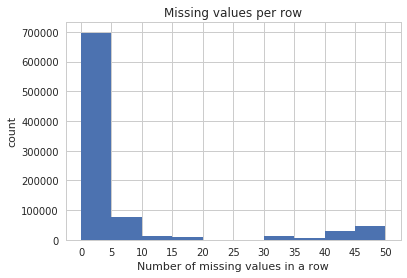

In [179]:
bins = np.arange(0, 47+5, 5);
plt.hist(na_rows, bins=bins);
plt.xticks(np.arange(0,47+5,5));
plt.xlabel('Number of missing values in a row')
plt.ylabel('count');
plt.title('Missing values per row');

In [180]:
# divide the data into two subsets based on the number of missing values in each row.

threshold = 20
subset_above = azdias_mapped_drop[na_rows > threshold]
subset_below = azdias_mapped_drop[na_rows <= threshold]
print("Below percentage of dataset {:0.2%}".format(subset_below.shape[0]/azdias.shape[0]))
print("Above percentage of dataset {:0.2%}".format(subset_above.shape[0]/azdias.shape[0]))


Below percentage of dataset 89.48%
Above percentage of dataset 10.52%


In [181]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# find columns which have 0 values missing
features = subset_below.columns[subset_below.isnull().sum()==0][:6]

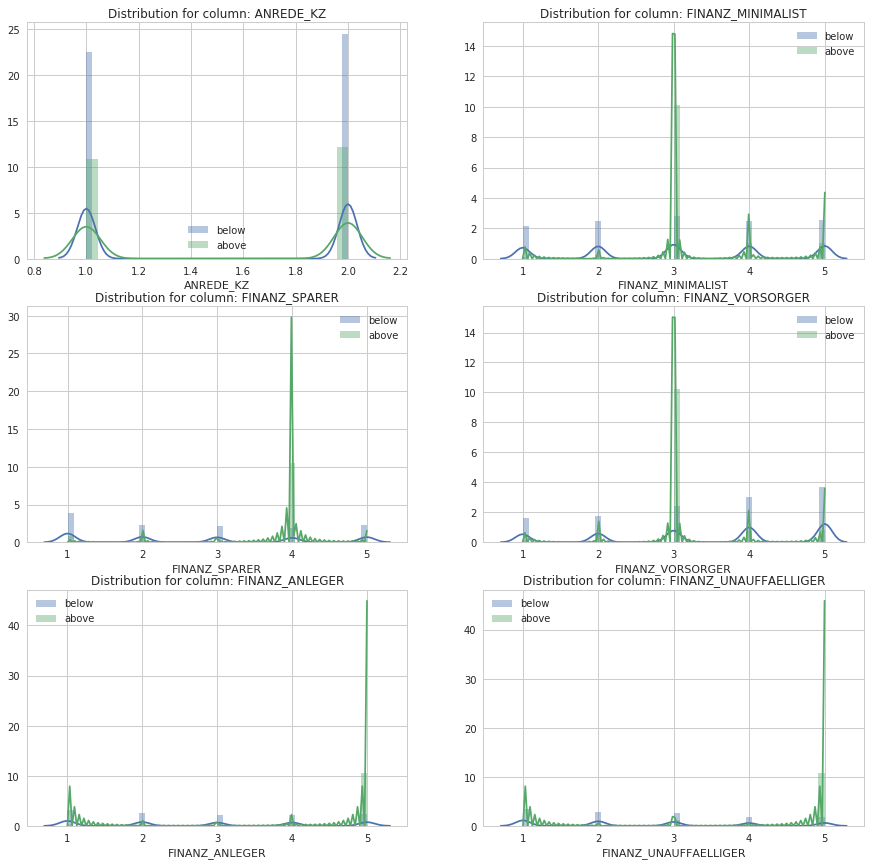

In [182]:
plt.figure(figsize=(15,20))
for i, col in enumerate(features):
    plt.subplot(4, 2, i+1)
    sns.distplot(subset_below[col], label='below')
    sns.distplot(subset_above[col], label='above')
    plt.title('Distribution for column: {}'.format(col))
    plt.legend();

#### Discussion 1.1.3: Assess Missing Data in Each Row


Observing the plot of 'Frequency of missing values', we can see that most of rows have less than 20 missing values. After dividing the dataset using threshold = 20 (subset_below and subset_above), the proportion of data in each dataset is: 

     - Below percentage of dataset 89.48%
    - Above percentage of dataset 10.52%
    
Then the distribution for the first 6 features were plotted. From these plots, it is possible to see that the distributions have a similar shape. Therefore, dropping the subset above the threshold from the analysis won't present a major issue. 


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

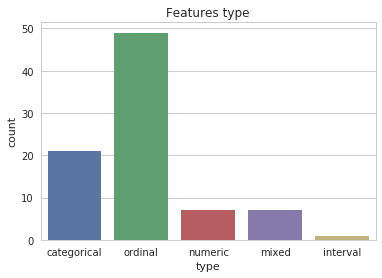

In [183]:
# Count how many features are there of each data type
feat_info['type'].value_counts()
g = sns.countplot(x=feat_info['type']);
g.set_title('Features type');

In [184]:
# Get categorical and mixed features names
categorical_feat = feat_info[feat_info['type']=='categorical']['attribute']
mixed_feat = feat_info[feat_info['type']=='mixed']['attribute']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [185]:
# Assess categorical variables: which are binary, which are multi-level

# remove features already dropped as outliers
categorical_feat = [feat for feat in categorical_feat if feat not in outliers_features]

# print categorical features levels
for feature in categorical_feat:
    levels = len(subset_below[feature].value_counts())
    print(feature, '|', subset_below[feature].dtypes, '|', levels)
         

ANREDE_KZ | int64 | 2
CJT_GESAMTTYP | float64 | 6
FINANZTYP | int64 | 6
GFK_URLAUBERTYP | float64 | 12
GREEN_AVANTGARDE | int64 | 2
LP_FAMILIE_FEIN | float64 | 11
LP_FAMILIE_GROB | float64 | 5
LP_STATUS_FEIN | float64 | 10
LP_STATUS_GROB | float64 | 5
NATIONALITAET_KZ | float64 | 3
SHOPPER_TYP | float64 | 4
SOHO_KZ | float64 | 2
VERS_TYP | float64 | 2
ZABEOTYP | int64 | 6
GEBAEUDETYP | float64 | 7
OST_WEST_KZ | object | 2
CAMEO_DEUG_2015 | object | 9
CAMEO_DEU_2015 | object | 44


In [186]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Reencode binary variable which have non-numeric value
d = {'W': 0, 'O': 1}
subset_below['OST_WEST_KZ'] = subset_below['OST_WEST_KZ'].map(d)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [187]:
subset_below['OST_WEST_KZ'].value_counts()

0    628987
1    168439
Name: OST_WEST_KZ, dtype: int64

In [188]:
# dropping features with more than 4 levels
drop_features = ['CAMEO_DEU_2015', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB',
                 'LP_FAMILIE_FEIN', 'LP_STATUS_GROB','LP_STATUS_FEIN', 'ZABEOTYP',
                 'CAMEO_DEUG_2015', 'GEBAEUDETYP', 'CJT_GESAMTTYP']

subset_below = subset_below.drop(labels=drop_features, axis=1)

In [189]:
# variables with 2 labels: don't do nothing
# encoding features with 3 or 4 levels
encoding_feat = ['NATIONALITAET_KZ','SHOPPER_TYP']
subset_below = pd.get_dummies(subset_below, columns=encoding_feat)
subset_below.shape

(797426, 73)

#### Discussion 1.2.1: Re-Encode Categorical Features

- The number of levels in each categorical feature were calculated. 
- The feature 'OST_WEST_KZ' with levels 'W' and 'O' was mapped to values 0 or 1.
- The features with more than 4 levels were dropped, the ones with 3 or 4 level were encoded using pd.get_dummies() and the features with 2 levels remains the same.
- The number of columns after dealing with the categorical features is 73.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [190]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

def map_year(val):
    if val==1 or val==2: return 1 # 40s
    elif val==3 or val==4: return 2 # 50s
    elif val==5 or val==6 or val==7: return 3 # 60s
    elif val==8 or val==9: return 4 # 70s
    elif val>=10 and val<=13: return 5 # 80s
    elif val==14 or val==15: return 6 # 90s

def map_movement(val):
    
    avantgarde = [2,4,6,7,9,11,13,15]
    mainstream = [1,3,5,8,10,12,14]
    
    if val in avantgarde: return 0
    elif val in mainstream: return 1
    
    
subset_below['PRAEGENDE_JUGENDJAHRE_YEAR'] = subset_below['PRAEGENDE_JUGENDJAHRE'].map(map_year)
subset_below['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = subset_below['PRAEGENDE_JUGENDJAHRE'].map(map_movement)


In [191]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def map_wealth(val):
    
    if val is not np.nan:
        return int(val)//10
    else:
        return val

def map_life_stage(val):
    
    if val is not np.nan:
        return int(val)%10
    else:
        return val

subset_below['CAMEO_INTL_2015_WEALTH'] = subset_below['CAMEO_INTL_2015'].map(map_wealth)
subset_below['CAMEO_INTL_2015_LIFE_STAGE'] = subset_below['CAMEO_INTL_2015'].map(map_life_stage)


In [192]:
# engineer new feature based on WOHNLAGE - Neighborhood quality (or rural flag)
# 1 is rural, 0 is city
def map_wohnlage_rural(val):
    
    not_rural = [0,1,2,3,4,5]
    rural = [7,8]
    
    if val in not_rural: return 0
    elif val in rural: return 1
    
subset_below['WOHNLAGE_RURAL'] = subset_below['WOHNLAGE'].map(map_wohnlage_rural);

In [193]:
# PLZ8_BAUMAX - Most common building type within the PLZ8 region
# 0 is family, 1 is business
    
def map_plz8_baumax(val):
    
    business = [5]
    
    if val in business: return 1
    else: return 0

subset_below['PLZ8_BAUMAX_BUSINESS'] = subset_below['PLZ8_BAUMAX'].map(map_plz8_baumax)

In [194]:
# remove mixed features from dataframe
mixed_feat = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE',
              'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']

subset_below = subset_below.drop(labels=mixed_feat, axis=1)
subset_below.shape

(797426, 73)

#### Discussion 1.2.2: Engineer Mixed-Type Features


- 6 new features were created from original mixed features: 
    - 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'
    - 'PRAEGENDE_JUGENDJAHRE_YEAR 
    - 'CAMEO_INTL_2015_WEALTH'
    - 'CAMEO_INTL_2015_LIFE_STAGE'
    - 'WOHNLAGE_RURAL' 
    - 'PLZ8_BAUMAX_BUSINESS'

- The original mixed features were dropped.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [195]:
subset_below.dtypes.value_counts()

float64    41
int64      25
uint8       7
dtype: int64

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [198]:
def replace_nan(dataframe):
    '''
    replace values in a column according to feat_info['attribute'] with np.nan
    '''
    features = feat_info['attribute']
    
    for feature in features:
        missing_str = feat_info[feat_info['attribute'] == feature]['missing_or_unknown']
        s = missing_str.values[0][1:][:-1].split(',')
        if s[0]:
            if(dataframe.dtypes[feature] == 'object'):
                d = {n: np.nan for n in list(map(lambda x: str(x), s))}
            else:
                d = {n: np.nan for n in list(map(lambda x: int(x), s))}

            dataframe[feature] = dataframe[feature].replace(d)
            
    return dataframe

def remove_outliers(dataframe):
    '''
    drop outliers columns
    '''
    
    outliers_features = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX',
                         'GEBURTSJAHR','ALTER_HH']
    dataframe = dataframe.drop(labels=outliers_features, axis=1)
    return dataframe

def select_subset(dataframe):
    '''
    divides dataframe in two subsets according to threshold
    '''
    
    threshold = 20
    na_rows = dataframe.isnull().sum(axis=1)
    subset_below = dataframe[na_rows <= threshold]
    return subset_below

def preprocessing_categorical(dataframe):
    
    # Reencode binary variable which have non-numeric value
    d = {'W': 0, 'O': 1}
    dataframe['OST_WEST_KZ'] = dataframe['OST_WEST_KZ'].map(d)
    
    # dropping features with more than 4 levels
    drop_features = ['CAMEO_DEU_2015', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB',
                 'LP_FAMILIE_FEIN', 'LP_STATUS_GROB','LP_STATUS_FEIN', 'ZABEOTYP',
                 'CAMEO_DEUG_2015', 'GEBAEUDETYP', 'CJT_GESAMTTYP']
    dataframe = dataframe.drop(labels=drop_features, axis=1)
    
    # variables with 2 labels: don't do nothing
    # encoding features with 3 or 4 level
    encoding_feat = ['NATIONALITAET_KZ','SHOPPER_TYP']
    dataframe = pd.get_dummies(dataframe, columns=encoding_feat)
    return dataframe

def preprocessing_mixed(dataframe):

    # engineer 6 new variables
    dataframe['PRAEGENDE_JUGENDJAHRE_YEAR'] = dataframe['PRAEGENDE_JUGENDJAHRE'].map(map_year)
    dataframe['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = dataframe['PRAEGENDE_JUGENDJAHRE'].map(map_movement)
    dataframe['CAMEO_INTL_2015_WEALTH'] = dataframe['CAMEO_INTL_2015'].map(map_wealth)
    dataframe['CAMEO_INTL_2015_LIFE_STAGE'] = dataframe['CAMEO_INTL_2015'].map(map_life_stage)
    dataframe['WOHNLAGE_RURAL'] = dataframe['WOHNLAGE'].map(map_wohnlage_rural);
    dataframe['PLZ8_BAUMAX_BUSINESS'] = dataframe['PLZ8_BAUMAX'].map(map_plz8_baumax);
    
    # remove mixed features from dataframe
    mixed_feat = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE'
                  , 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
    dataframe = dataframe.drop(labels=mixed_feat, axis=1)
    
    return dataframe

In [199]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # remove selected columns and rows, ...
    # select, re-encode, and engineer column values.
    # Return the cleaned dataframe.
    x = replace_nan(df)
    x = remove_outliers(x)
    x = select_subset(x)
    x = preprocessing_categorical(x)
    x = preprocessing_mixed(x)
    return x

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [200]:
# Fill missing values
inputer = Imputer(missing_values=np.nan, strategy='most_frequent', axis=0)
X = inputer.fit_transform(subset_below)

In [201]:
X = pd.DataFrame(X)
X.columns = subset_below.columns

In [203]:
X.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_YEAR,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,WOHNLAGE_RURAL,PLZ8_BAUMAX_BUSINESS
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,0.0,1.0,6.0,1.0,5.0,1.0,0.0,0.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,1.0,0.0,6.0,0.0,2.0,4.0,0.0,0.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,1.0,0.0,0.0,4.0,1.0,1.0,2.0,1.0,0.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,1.0,0.0,4.0,1.0,4.0,3.0,0.0,0.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,0.0,0.0,0.0,2.0,1.0,5.0,4.0,1.0,0.0


In [204]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

### Discussion 2.1: Apply Feature Scaling


The missing values were replaced by the most common value in the columns. Then, standard scaler (remove the mean and scale to unit variance) were applied to the data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [205]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(797426, 73)

In [206]:
def scree_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_yticks(np.arange(0,1+0.1,0.1))
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [207]:
# first 5 components explained variance
pca.explained_variance_ratio_[:5].sum()


0.44112618930467845

In [208]:
# components higher than 30 explained variance
pca.explained_variance_ratio_[30:].sum()

0.15332737516952888

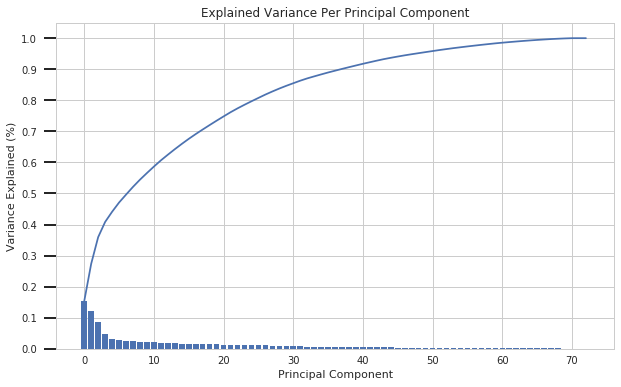

In [209]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [253]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(797426, 30)

### Discussion 2.2: Perform Dimensionality Reduction


The Scree plot shows the amount of variability explained by each principal component. The amount of variability explained are the eigenvalues and the principal components themselves are the eigenvectors. After 30 components, the variability per component is very small. The value chosen for the number of principal components  will be 30 and results in about 85% of variability explained.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [254]:
feat_names = subset_below.columns
def pca_weight(pca, n):
    d = {}
    for i, f in enumerate(feat_names):
        d[f] = pca.components_[n][i]
    return sorted(d.items(), key=lambda kv: kv[1], reverse=True)

In [255]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
d = pca_weight(pca, 0)
d

[('PLZ8_ANTG3', 0.22196066321120969),
 ('PLZ8_ANTG4', 0.21501683340909034),
 ('ORTSGR_KLS9', 0.20007853179078355),
 ('CAMEO_INTL_2015_WEALTH', 0.19796518728495097),
 ('EWDICHTE', 0.19686843325871853),
 ('HH_EINKOMMEN_SCORE', 0.19386457690964967),
 ('FINANZ_HAUSBAUER', 0.15474789985905824),
 ('PLZ8_ANTG2', 0.15103884322704225),
 ('KBA05_ANTG4', 0.15075289966466138),
 ('PLZ8_BAUMAX_BUSINESS', 0.14412997661094532),
 ('FINANZ_SPARER', 0.14245108350986749),
 ('ARBEIT', 0.14127784000261825),
 ('RELAT_AB', 0.13435148871553812),
 ('ANZ_HAUSHALTE_AKTIV', 0.13299792503208804),
 ('KBA05_ANTG3', 0.13127730287642794),
 ('SEMIO_PFLICHT', 0.11325898563806087),
 ('SEMIO_REL', 0.11046629357146154),
 ('PRAEGENDE_JUGENDJAHRE_YEAR', 0.10308745750201281),
 ('PRAEGENDE_JUGENDJAHRE_MOVEMENT', 0.1009395908194997),
 ('SEMIO_RAT', 0.092858503005929668),
 ('SEMIO_TRADV', 0.085753126622770903),
 ('SEMIO_MAT', 0.076909211411447187),
 ('SEMIO_FAM', 0.075435046370931833),
 ('FINANZ_UNAUFFAELLIGER', 0.073801155173564

In [261]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
d = pca_weight(pca, 1)
d

[('ALTERSKATEGORIE_GROB', 0.25387115299079183),
 ('SEMIO_ERL', 0.23187334294012124),
 ('FINANZ_VORSORGER', 0.22494803410928207),
 ('SEMIO_LUST', 0.17820187416133593),
 ('RETOURTYP_BK_S', 0.15631943086036293),
 ('SEMIO_KAEM', 0.12073781046637669),
 ('SEMIO_KRIT', 0.11983700718174131),
 ('FINANZ_HAUSBAUER', 0.1126056860413238),
 ('W_KEIT_KIND_HH', 0.107576157894772),
 ('ANREDE_KZ', 0.098314643089101525),
 ('SHOPPER_TYP_3.0', 0.0965658024799909),
 ('EWDICHTE', 0.093538162458797841),
 ('ORTSGR_KLS9', 0.09300796458800295),
 ('PLZ8_ANTG3', 0.090676070080660406),
 ('PLZ8_ANTG4', 0.08901362288334165),
 ('SEMIO_DOM', 0.080510993203772557),
 ('NATIONALITAET_KZ_1.0', 0.070672958542694689),
 ('CAMEO_INTL_2015_WEALTH', 0.069058782918195033),
 ('KBA05_ANTG4', 0.06877837143143635),
 ('ARBEIT', 0.067207662881046112),
 ('RELAT_AB', 0.064744236087681678),
 ('FINANZ_MINIMALIST', 0.063297618776921499),
 ('PLZ8_ANTG2', 0.062294133254677336),
 ('ANZ_HAUSHALTE_AKTIV', 0.060195884401484427),
 ('WOHNDAUER_2008

In [262]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

d = pca_weight(pca, 2)
d

[('SEMIO_VERT', 0.33505527491760928),
 ('SEMIO_SOZ', 0.25504431984158021),
 ('SEMIO_FAM', 0.23817559439196068),
 ('SEMIO_KULT', 0.22140374245716329),
 ('FINANZ_MINIMALIST', 0.15361080588250542),
 ('SHOPPER_TYP_0.0', 0.12628125193976453),
 ('RETOURTYP_BK_S', 0.10943731467371504),
 ('FINANZ_VORSORGER', 0.10648590025401465),
 ('W_KEIT_KIND_HH', 0.087378989673841945),
 ('ALTERSKATEGORIE_GROB', 0.084357212044553251),
 ('SEMIO_LUST', 0.067823999064121648),
 ('SEMIO_REL', 0.059172198454103778),
 ('ORTSGR_KLS9', 0.053664786736321003),
 ('EWDICHTE', 0.052003207381071066),
 ('PLZ8_ANTG4', 0.050398524253016039),
 ('GREEN_AVANTGARDE', 0.049611232592007566),
 ('PLZ8_ANTG3', 0.048723534905256896),
 ('SHOPPER_TYP_1.0', 0.048380375999470794),
 ('SEMIO_MAT', 0.046742888587355036),
 ('PLZ8_BAUMAX_BUSINESS', 0.040435761363729311),
 ('ARBEIT', 0.038191986842327122),
 ('NATIONALITAET_KZ_1.0', 0.037448150322815787),
 ('RELAT_AB', 0.035058847120629594),
 ('WOHNDAUER_2008', 0.033861833255811727),
 ('PLZ8_ANTG

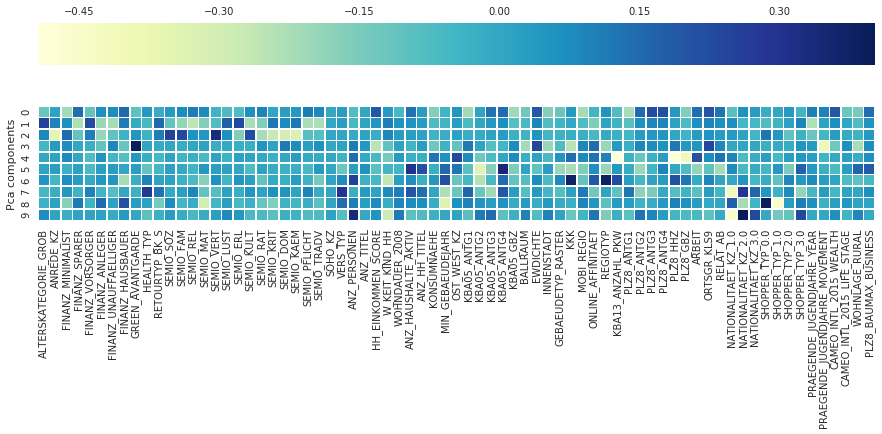

In [263]:
# Look for the first 10 components of PCA to see which original features had highest weights

fig, ax = plt.subplots(figsize=(15, 15))
g = sns.heatmap(pca.components_[:10], ax=ax, square=True, cmap="YlGnBu", 
            cbar_kws = dict(use_gridspec=False,location="top"), linewidths=.5);
g.set_xticklabels(subset_below.columns);
g.set_ylabel('Pca components');


### Discussion 2.3: Interpret Principal Components


**First component analysis:**

1. The first principal component is positively correlated with features regarding:
    - the household wealth/income (CAMEO_INTL_2015_WEALTH, HH_EINKOMMEN_SCORE), 
    - the quantity of larger families in region (PLZ8_ANTG3, PLZ8_ANTG4)
    - the density of households in region (EWDICHTE)

These features vary together, so high values means larger families living in
more dense regions and with a large income/wealth.

2. This component increase with the decrease of features (negative correlated): 
    - the quantity of small households with lower financial typology (PLZ8_ANTG1, KBA05_ANTG1,FINANZ_MINIMALIST)
    - number of buildings in region (KBA05_GBZ)
    
Which represents the number of buildings with smaller family capacity and less
expressive financial typology. 
 
3. This suggests that this first feature is about wealth and the size of the family.

**Second component analysis**


1. The second principal component is positively correlated with features regarding:
    - age (ALTERSKATEGORIE_GROB, high values means older), 
    - personality type for event-oriented (SEMIO_ERL, high values meaning low affinity)
    - financial typology  for prepared (FINANZ_VORSORGER - be prepared, high values meaning low affinity)

These features vary together, so high values means older persons, less event-oriented and
not much financial prepared. 
 
2. This second component increase with the decrease of features (negative correlated): 
    - the age (PRAEGENDE_JUGENDJAHRE_YEAR, the less the older)
    - personality typology for tradional/cultural/religious-minded (SEMIO_KULT, SEMIO_PFLICHT, SEMIO_TRADV)
    - financial typology for money-saver(FINANZ_SPARER)
   
These features vary together, so decrease them means older persons, with more  traditional/cultural/religious personalities and money-savers.

3. This suggests that this first feature is about older persons and financial habits regarding preparing habits.

**Third component analysis**

1. The third principal component is positively correlated with features regarding:
   
    - personality typology  ('SEMIO_VERT', 'SEMIO_SOZ','SEMIO_FAM','SEMIO_KULT')
 
These features vary together, so high values means less affinity for personalities like dreamful/socially/family/cultural

2. This third principal component increase with the decrease of features (negative correlated):

    - personality typology('SEMIO_KRIT', 'SEMIO_DOM','SEMIO_KAEM')
    - gender ('ANREDE_KZ')

These features vary together, so decrease them means more critical/dominat/combative personalities, probably more complicated to communicate.

3. This suggests that this third feature is about more strict personality typologies.


Reference: https://newonlinecourses.science.psu.edu/stat505/node/54/

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [265]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.

ks = []
scores = []
for k in np.arange(0,20,2):
    print(k+1)
    ks.append(k+1)
    kmeans = KMeans(n_clusters=k+1)
    model = kmeans.fit(X_pca)
    score = abs(model.score(X_pca))
    scores.append(score)

1
3
5
7
9
11
13
15
17
19


(1, 19)

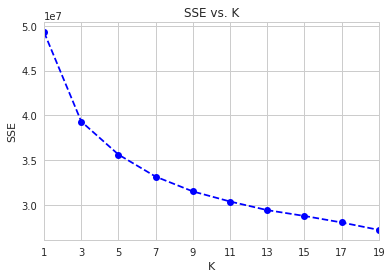

In [268]:
# Investigate the change in within-cluster distance across number of clusters.

# Plot the score against k
plt.plot(ks, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
plt.xticks(ks);
plt.xlim(1,19)


In [276]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=19)
model = kmeans.fit(X_pca)
preds = model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

KMeans were performed on the reduced dataset (X_pca) containing 30 features. The scores for k from 1 to 19 were described on the Scree Plot, where a good value for k would be the point where adding another cluster (increasing k) does not decrease SSE significantly. There is no clear elbow point in the plot, therefore the value that gives the lowest SSE(k=19) will be used in the next steps.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [277]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [278]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
n_before = customers.shape[0]

In [279]:
# preprocessing
customers = clean_data(customers)
n_after = customers.shape[0]

In [280]:
print("Proportion of dataset customers after cleaning data:{:0.2%}".format(n_after/n_before))

Proportion of dataset customers after cleaning data:73.90%


In [281]:
# fill nan values
#inputer = Imputer(missing_values=np.nan, strategy='most_frequent', axis=0)
Xc = inputer.transform(customers)
Xc = pd.DataFrame(Xc)
Xc.columns = customers.columns

In [282]:
# Apply feature scaling to the general population demographics data.
#scaler = StandardScaler()
Xc_scaled = scaler.transform(Xc)
Xc_scaled = pd.DataFrame(Xc_scaled)

In [283]:
# Apply PCA
Xc_pca = pca.transform(Xc_scaled)
Xc_pca.shape

(141640, 30)

In [284]:
# Clustering
preds_c = kmeans.predict(Xc_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [302]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [287]:
# Calculate proportions of persons in each cluster
n = X_pca.shape[0]
nc = Xc_pca.shape[0]

proportions_general = pd.Series(preds).value_counts().sort_index()/n
proportions_cust = pd.Series(preds_c).value_counts().sort_index()/nc

df = pd.DataFrame({'cluster': proportions_general.index,
                  'p_general': proportions_general.values,
                  'p_customer':proportions_cust.values})


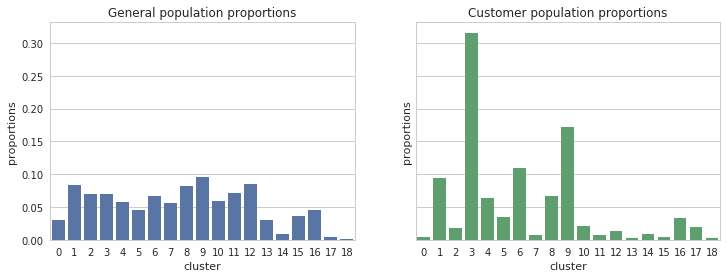

In [288]:
# Plot proportions 
base_color2 = sns.color_palette()[1]
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4), sharey=True)
g = sns.barplot(x="cluster", y="p_general", data=df,
                color=base_color, ax=ax1);
g.set_title('General population proportions');
g.set_ylabel('proportions');

g2 = sns.barplot(x="cluster", y="p_customer", data=df,
                color=base_color2, ax=ax2);
g2.set_title('Customer population proportions');
g2.set_ylabel('proportions');


In [321]:
def plot_scaled_comparison(df_sample, kmeans, cluster):
    '''
    visualize weights of features after apply pca.inverse_transform on cluster centroid
    '''
    centroid = kmeans.cluster_centers_[cluster]
    
    X = pd.DataFrame.from_dict(
        dict(zip(df_sample.columns, pca.inverse_transform(centroid))),orient='index').rename(columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');


In [314]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

clusters_over = {}

for i in range(19):
    
    pc =  df['p_customer'][i]
    pg = df['p_general'][i]
    
    if pc > pg:
        clusters_over[i] = abs(pc-pg)*100 # percentage diff

clusters_over

{1: 0.99262907067709516,
 3: 24.51821067311468,
 4: 0.53984219147445234,
 6: 4.3955573502958991,
 9: 7.6950951076645175,
 14: 0.12348868321157402,
 17: 1.4903457983092512,
 18: 0.1412460168819667}

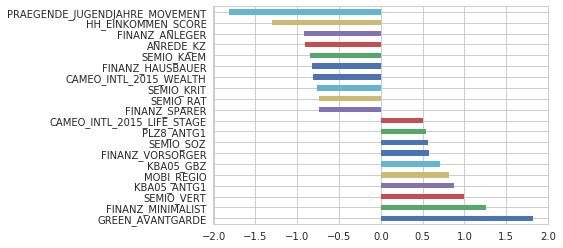

In [320]:
# cluster 3 with most significant difference from general data
plot_scaled_comparison(customers, kmeans, 3)
# The data weights are scaled, meaning:
# more negatives values represents lower values for feature
# positive values represents higher values for features

**Interpretation for cluster 3**
- It is possible to see that: 
    1. The features 'GREEN_AVANTGARDE' and 'FINANZ_MINIMALIST' have the highest values, meaning these people are member of green avantgarde and don't have low financial interest (probably have investments, stocks). 
    2. The features 'HH_EINKOMMEN_SCORE' and 'PRAEGENDE_JUGENDJAHRE_MOVEMENT' have lowest values. They represent wealthy people member of the green avantgarde movement.



In [339]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

clusters_under = {}

for i in range(19):
    
    pc =  df['p_customer'][i]
    pg = df['p_general'][i]
    
    if pg > pc:
        clusters_under[i] = abs(pg-pc)*100 # percentage diff
        
clusters_under

{0: 2.5322405739223361,
 2: 5.1107555546698418,
 5: 1.1749475056440299,
 7: 4.9591385880653887,
 8: 1.6188156028848573,
 10: 3.7525107869078784,
 11: 6.4583582022800279,
 12: 7.1807195274206235,
 13: 2.6740065389421814,
 15: 3.2211503510285096,
 16: 1.2137716598637618}

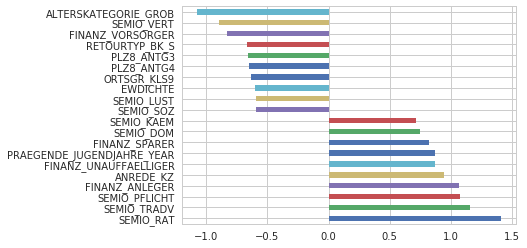

In [340]:
# cluster 12 underrepresented compared to general data
plot_scaled_comparison(customers, kmeans, 12)
# The weights are scaled, meaning:
# more negatives values represents lower values for feature
# positive values represents higher values for features

**Interpretation for cluster 3**

- It is possible to see that:
    1. The features 'SEMIO_RAT/TRADV/PFLICHT' and 'FINANZ_ANLEGER' have the highest values, representing people that are probably not investors and have low affinity for personality traits like rational/tradional/dutiful.

    2. The features 'ALTERSKATEGORIE_GROB','FINANZ_VORSORGER,'SEMIO_VERT' have the lowest values, representing people that are younger, prepared financially and have high affinity for personality traits like dreamful.

### Discussion 3.3: Compare Customer Data to Demographics Data

The segments of population that are popular with the mail-order company are wealthy and member of green avantgarde. The less segments of population that are less popular representes younger people and not so wealthy (don't have investments).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.